In [1]:
%load_ext autoreload
from tensorboardX import SummaryWriter  
from IPython.core.debugger import set_trace
import os
from collections import defaultdict 
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
from torch import autograd
import torch.nn.functional as F
import torchvision
import torchio as tio

from models.v2v import V2VModel
import matplotlib.pyplot as plt
import yaml
from easydict import EasyDict as edict
from utils import video_comparison, video, get_capacity
from celluloid import Camera
from IPython.core.display import HTML
from IPython.core.debugger import set_trace
from losses import DiceScoreBinary, DiceLossBinary
from datasets import create_datasets

%autoreload 2

In [2]:
!nvidia-smi

Wed Apr 13 12:09:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 460.27.04    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX TIT...  Off  | 00000000:02:00.0 Off |                  N/A |
| 22%   32C    P8    13W / 250W |    874MiB / 12211MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX TIT...  Off  | 00000000:03:00.0 Off |                  N/A |
| 22%   

In [3]:
MAKE_LOGS = False
SAVE_MODEL = False
DEVICE = 'cpu'
plt.rcParams['font.size'] = 20

In [4]:
# logdir = './logs/logs_approach_comparison/v2v_whole_s128_bs1_GN_Dice-BCE250_lr1e-3_ALL-MNI152-AUG@04.04.2022-23:31:41'
# logdir = './logs_approach_comparison/v2v_whole_s128_bs1_GN_Dice_lr1e-3_ALL-MNI152-AUG@04.04.2022-23:12:47'
logdir = './logs/logs_BRATS/v2v128_whole_s128_bs1_GN_Dice_lr1e-3_BRATS-AUG@12.04.2022-23:16:44'

In [5]:
val_preds_path = os.path.join(logdir, 'best_val_preds')

In [6]:
os.listdir(val_preds_path)

['332',
 '316',
 '228',
 '043',
 '011',
 '295',
 '055',
 '217',
 '299',
 '291',
 '314',
 '208',
 '129',
 '331',
 '022',
 '246',
 '057',
 '191',
 '317',
 '245',
 '290',
 '184',
 '065',
 '212',
 '025',
 '225',
 '138',
 '079',
 '308',
 '222',
 '360',
 '342',
 '157',
 '006',
 '009',
 '238',
 '218',
 '131',
 '130',
 '315',
 '078',
 '214',
 '118',
 '330',
 '030',
 '031',
 '197',
 '087',
 '077',
 '168',
 '178',
 '113',
 '054',
 '368',
 '312',
 '227',
 '182',
 '048',
 '010',
 '021',
 '216',
 '117',
 '196',
 '303',
 '028',
 '349',
 '198',
 '071',
 '090',
 '333',
 '266',
 '093',
 '040',
 '324',
 '163',
 '327',
 '297',
 '060',
 '310',
 '167',
 '027',
 '346',
 '082',
 '185',
 '175',
 '277',
 '234',
 '174',
 '278',
 '232',
 '343',
 '223',
 '336']

In [7]:
# weights_path = os.path.join(logdir, 'checkpoints')
# os.listdir(weights_path)

In [8]:
best_val_preds = {}
for label in os.listdir(val_preds_path):
    val_preds_label_path = os.path.join(val_preds_path, label)
    best_val_preds[label] = torch.load(val_preds_label_path)[0,0]

### Load model, setup dataloaders

In [9]:
with open(os.path.join(logdir, 'config.yaml')) as fin:
    config = edict(yaml.safe_load(fin))

In [10]:
# config.dataset.dataset_type = 'fcd'

In [11]:
# essential for the proper samplers functioning
assert config.opt.val_batch_size == 1
assert config.opt.train_batch_size == 1
device = torch.device(DEVICE)

#########
# MODEL #
#########
# if config.model.name == "v2v":
#     model = V2VModel(config).to(device)
# elif config.model.name == "unet3d":
#     model = UnetModel(config).to(device)
    
# model_dict = torch.load(os.path.join(logdir, 'checkpoints/weights_80.pth'))
# print(f'LOADING from {logdir} \n epoch:', model_dict['epoch'])
# model.load_state_dict(model_dict['model_state'])


###################
# CREATE DATASETS #
###################
train_dataset, val_dataset = create_datasets(config)
collate_fn = None
train_dataloader = DataLoader(train_dataset,
                                batch_size=config.opt.train_batch_size,
                                shuffle=False,
                                collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset,
                            batch_size=config.opt.val_batch_size,
                            shuffle=False,
                            collate_fn=collate_fn)
print(len(train_dataloader), len(val_dataloader))

print('val dataloder len: ', len(val_dataloader), 'train dataloder len: ', len(train_dataloader))

276 93
val dataloder len:  93 train dataloder len:  276


# Forward pass

In [12]:
dataloader = val_dataloader

In [17]:
brains = {}
labels_gt = {}
metric_dict = defaultdict(dict)
labels_pred = {}

# model.train(True)
# model.eval()

iterator = enumerate(dataloader)
labels = dataloader.dataset.labels

with torch.no_grad():

    # bs = 1
    # brain_tensor - [1,C,H,W,D]
    # mask_tensor - [1,1,H,W,D]
    # label_tensor - [1,1,H,W,D]
    
    #######################
    # ITERATE OVER BRAINS #
    #######################
    for iter_i, (brain_tensor, mask_tensor, label_tensor) in tqdm(iterator):
        
        if config.interpolate:
            brain_tensor = F.interpolate(brain_tensor, config.interpolation_size).to(device)
            label_tensor = F.interpolate(label_tensor, config.interpolation_size).to(device)
            mask_tensor = F.interpolate(mask_tensor.type(torch.float), 
                                        config.interpolation_size).type(torch.bool).to(device)
        
        label = labels[iter_i]
        
         # forward pass
#         label_tensor_predicted = model(brain_tensor) # -> [bs,1,ps,ps,ps]
        
        label_tensor_predicted = torch.tensor(best_val_preds[label][None,None,...])
        
        dice_score = DiceScoreBinary(label_tensor_predicted, label_tensor)
        coverage = (label_tensor_predicted*label_tensor).sum() / label_tensor.sum()
        
        print(f'Label: {label}, dice: {dice_score}')
            
        metric_dict['coverage'][label] = coverage.item()
        metric_dict['dice_score'][label] = dice_score.item()
        brains[label] = brain_tensor[0].detach().cpu().numpy()
        labels_gt[label] = label_tensor[0,0].detach().cpu().numpy()
        labels_pred[label] = label_tensor_predicted[0,0].detach().cpu().numpy()
        
        


1it [00:00,  2.53it/s]

Label: 071, dice: 0.9271714091300964


2it [00:00,  2.95it/s]

Label: 130, dice: 0.9014624953269958


3it [00:00,  3.18it/s]

Label: 163, dice: 0.9768484234809875


4it [00:01,  3.24it/s]

Label: 246, dice: 0.8852960467338562


5it [00:01,  3.25it/s]

Label: 238, dice: 0.868430495262146


6it [00:01,  3.09it/s]

Label: 212, dice: 0.8902815580368042


7it [00:02,  3.19it/s]

Label: 054, dice: 0.9062703847885132


8it [00:02,  3.32it/s]

Label: 297, dice: 0.8310187458992004


9it [00:02,  3.30it/s]

Label: 021, dice: 0.7940876483917236


10it [00:03,  3.44it/s]

Label: 138, dice: 0.9218791723251343


11it [00:03,  3.46it/s]

Label: 043, dice: 0.8525574207305908


12it [00:03,  3.44it/s]

Label: 057, dice: 0.945205569267273


13it [00:03,  3.42it/s]

Label: 360, dice: 0.9296964406967163


14it [00:04,  3.51it/s]

Label: 266, dice: 0.9544928669929504


15it [00:04,  3.55it/s]

Label: 022, dice: 0.9498255252838135


15it [00:04,  3.14it/s]


KeyboardInterrupt: 

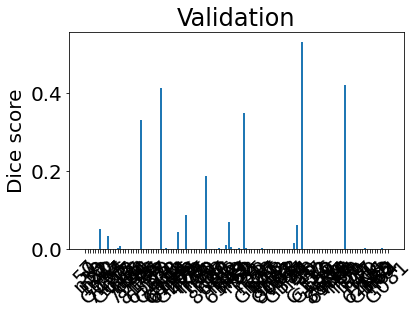

In [20]:
plt.ion()
plt.figure()
plt.bar(metric_dict['dice_score'].keys(), metric_dict['dice_score'].values())
exp_name = logdir.split('/')[1]
plt.title(f'Validation')
plt.ylabel('Dice score')
plt.xticks(rotation=45)
plt.show()

In [62]:
labels[dices > 0.2]

TypeError: only integer scalar arrays can be converted to a scalar index

In [64]:
dices = np.array(list(metric_dict['dice_score'].values()))
labels = np.array(list(metric_dict['dice_score'].keys()))

In [83]:
labels[(dices > 0.1) & (dices < 0.7)]

array(['81NS', '20', '82', '60', '31', '13'], dtype='<U4')

In [44]:
len(labels[dices < 0.1]), len(labels)

(115, 121)

### hard examples

DiceBCE:
 - val: [n11, n5, G258, G324]    
 - train: ['50', '7', 'n39', '18', 'n22', 'n40', '51', 'G044', '42', '74NS',
       'n55', '57', 'G015', '4', 'n72', '17', 'n48', 'n65', '79NS', 'n54',
       '26', '40', 'n76', '23', '65NS', '34', 'n37', '32', 'G409', 'n38',
       '68NS', 'G184', '67NS', 'n74', '14', 'G294', 'n63', 'n75', '39',
       'n69', 'n77', 'n35', '21', 'n61', 'n70', '16', 'n68', '86NS',
       'n60', '27', '49', 'n16', 'n82', '63NS', 'n19', 'n49', 'n67', 'n9',
       'n52', '59', '53', 'n51', 'n79', '45', 'G177', 'n28', 'n66', 'n57',
       'n45', 'n13', 'n32', 'G061', '80NS', 'n73', 'n83', '41', 'G371',
       'n47', '8', 'n24', '84', '44', '28', '10', 'G133', 'n7', 'G150',
       '52', 'n59', '46', 'n26', '88NS', '69NS', 'n44', 'n36', 'n78',
       '22', 'n84', 'n81', '30', 'n71', '19', 'n17', 'n41', '11', '62NS',
       '29', 'n14', 'G368', 'n43', 'n80', 'n62', 'n64', '35', 'G081']

DICE:
 - val [38, 1, 48, n11]


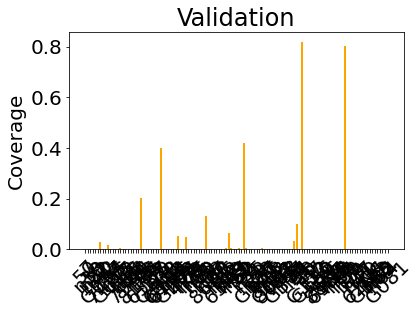

In [39]:
plt.ion()
plt.figure()
plt.bar(metric_dict['coverage'].keys(), metric_dict['coverage'].values(), color='orange')
exp_name = logdir.split('/')[1]
plt.title(f'Validation')
plt.ylabel('Coverage')
plt.xticks(rotation=45)

plt.show()

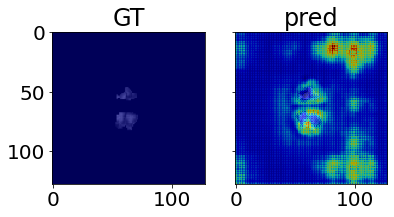

In [57]:
label = '31'

plt.ioff()
camera = video_comparison([brains[label][5], brains[label][5]], 
                          [labels_gt[label], labels_pred[label]], 
                          titles=['GT', 'pred'],
                          n_slides=128)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

In [ ]:
array(['81NS', '20', '82', '60', '31', '13']

In [101]:
bad_labels = ['n55', '57', 'G015', '4', 'n72', '17', 'n48', 'n65', '79NS', 'n54',
'26', '40', 'n76', '23', '65NS', '34', 'n37', '32', 'G409', 'n38',
'68NS', 'G184', '67NS', 'n74', '14', 'G294', 'n63', 'n75', '39',
'n69', 'n77', 'n35', '21', 'n61', 'n70', '16', 'n68', '86NS',
'n60', '27', '49', 'n16', 'n82', '63NS', 'n19', 'n49', 'n67', 'n9',
'n52', '59', '53', 'n51', 'n79', '45', 'G177', 'n28', 'n66', 'n57',
'n45', 'n13', 'n32', 'G061', '80NS', 'n73', 'n83', '41', 'G371',
'n47', '8', 'n24', '84', '44', '28', '10', 'G133', 'n7', 'G150',
'52', 'n59', '46', 'n26', '88NS', '69NS', 'n44', 'n36', 'n78',
'22', 'n84', 'n81', '30', 'n71', '19', 'n17', 'n41', '11', '62NS',
'29', 'n14', 'G368', 'n43', 'n80', 'n62', 'n64', '35', 'G081']

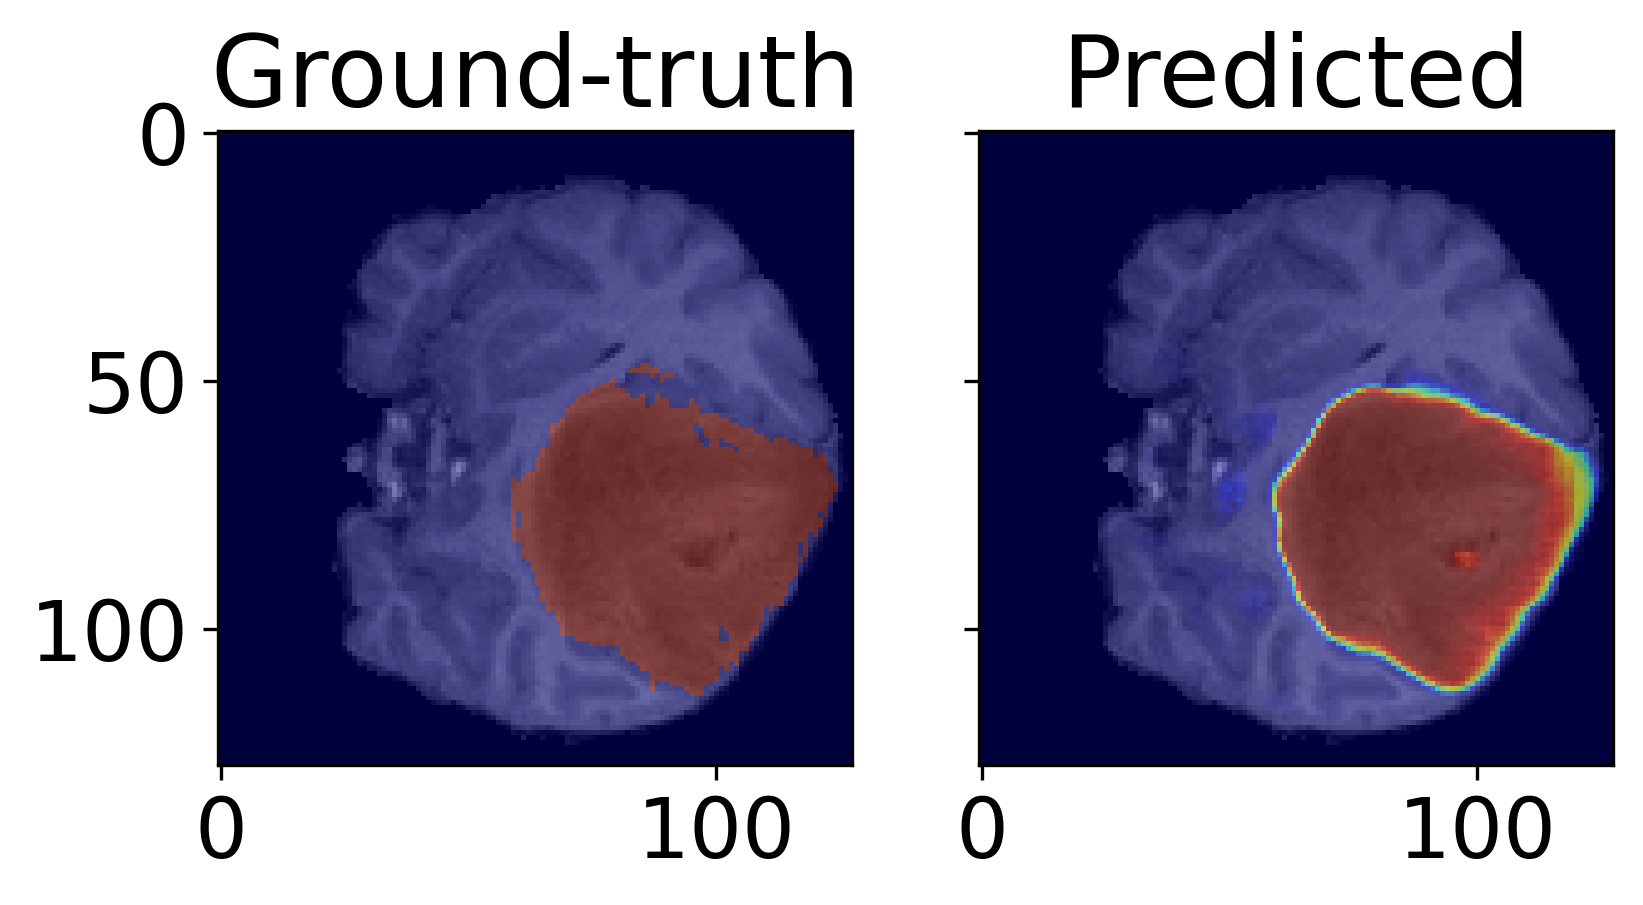

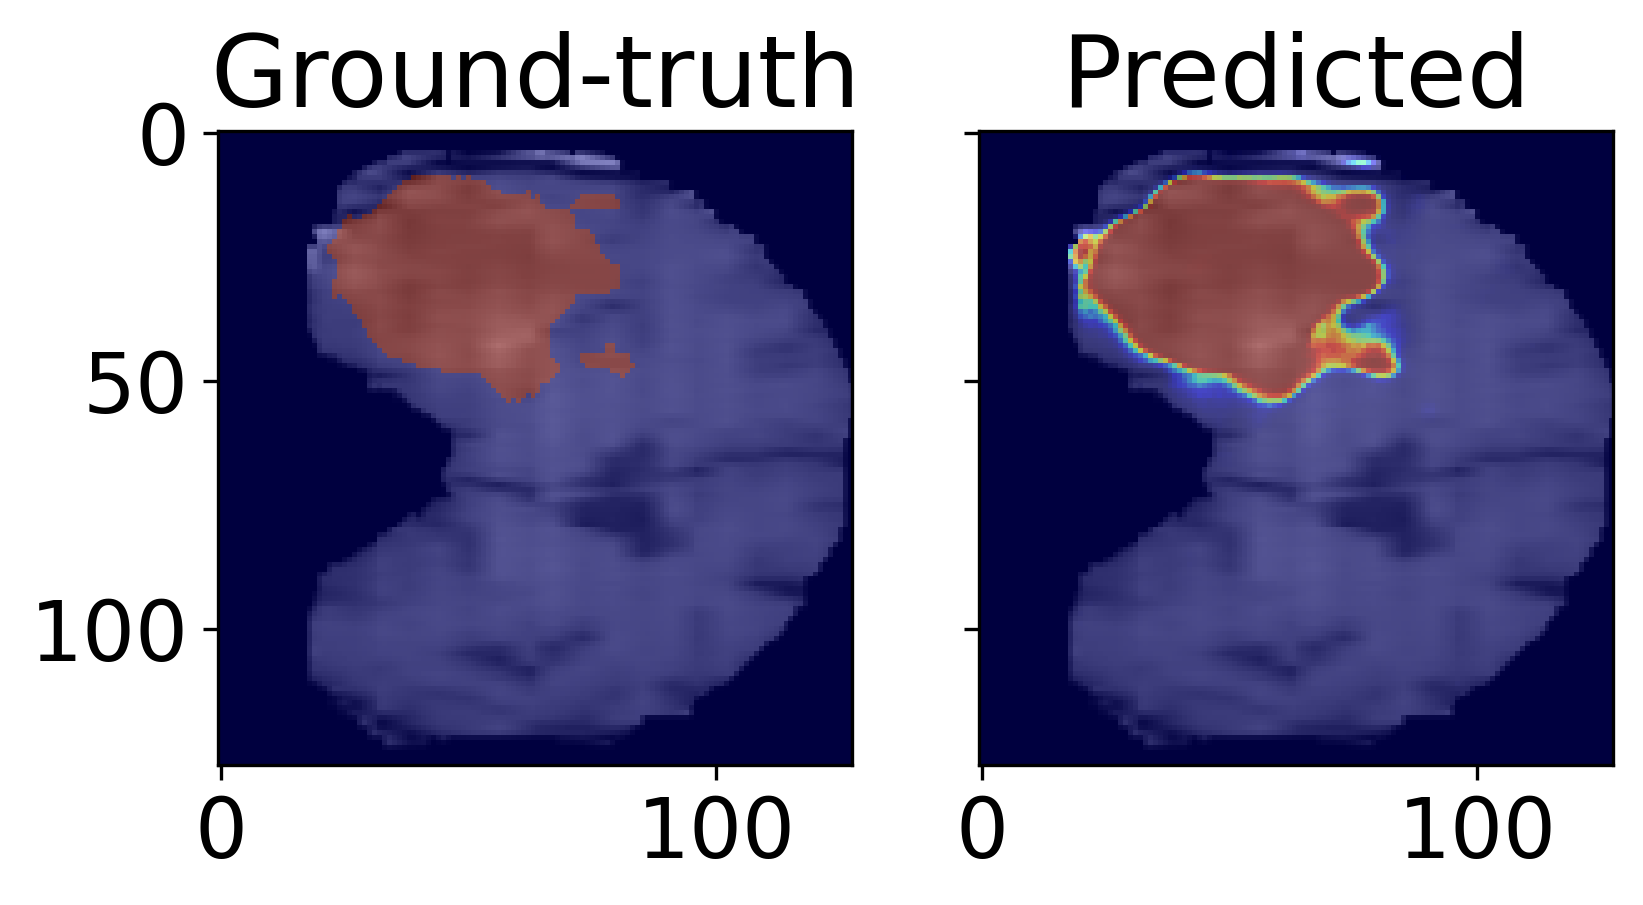

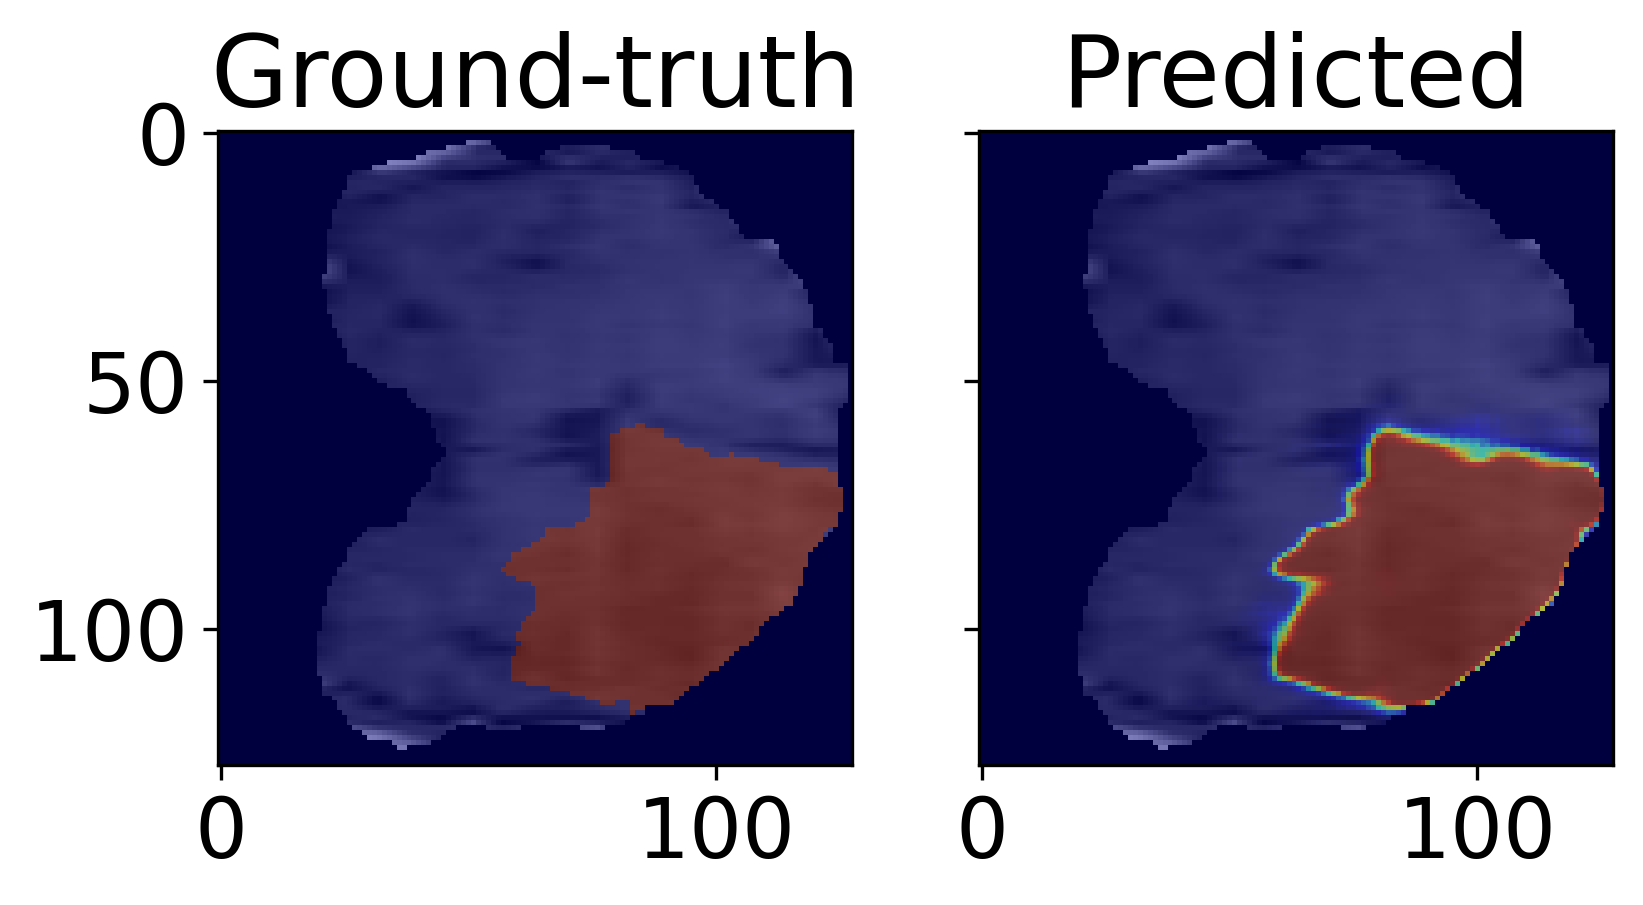

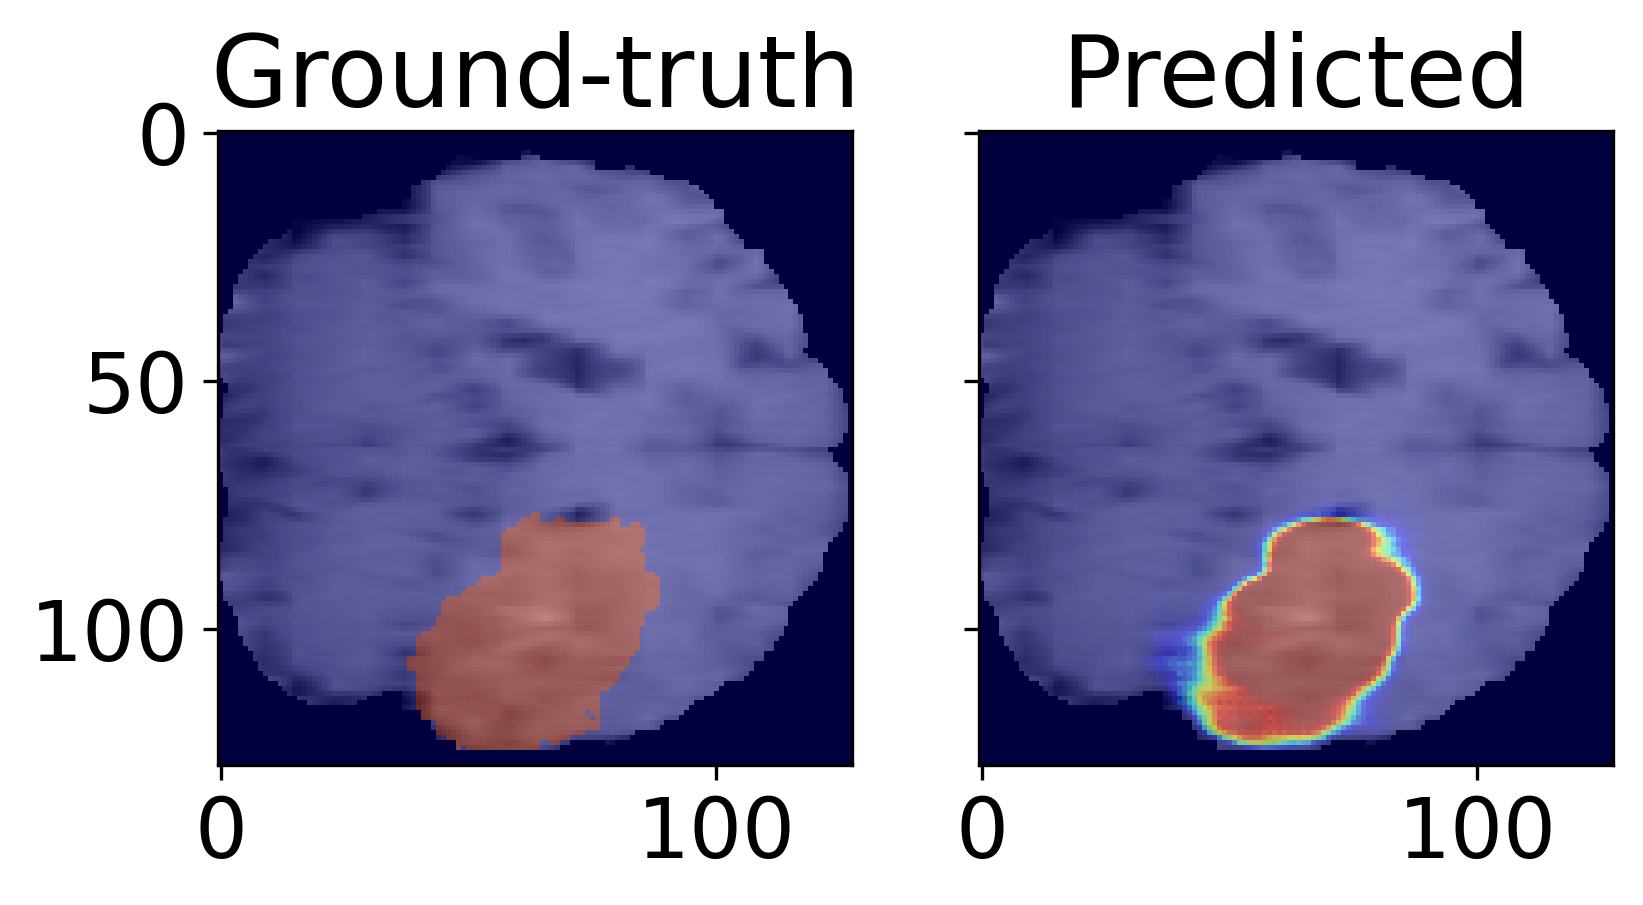

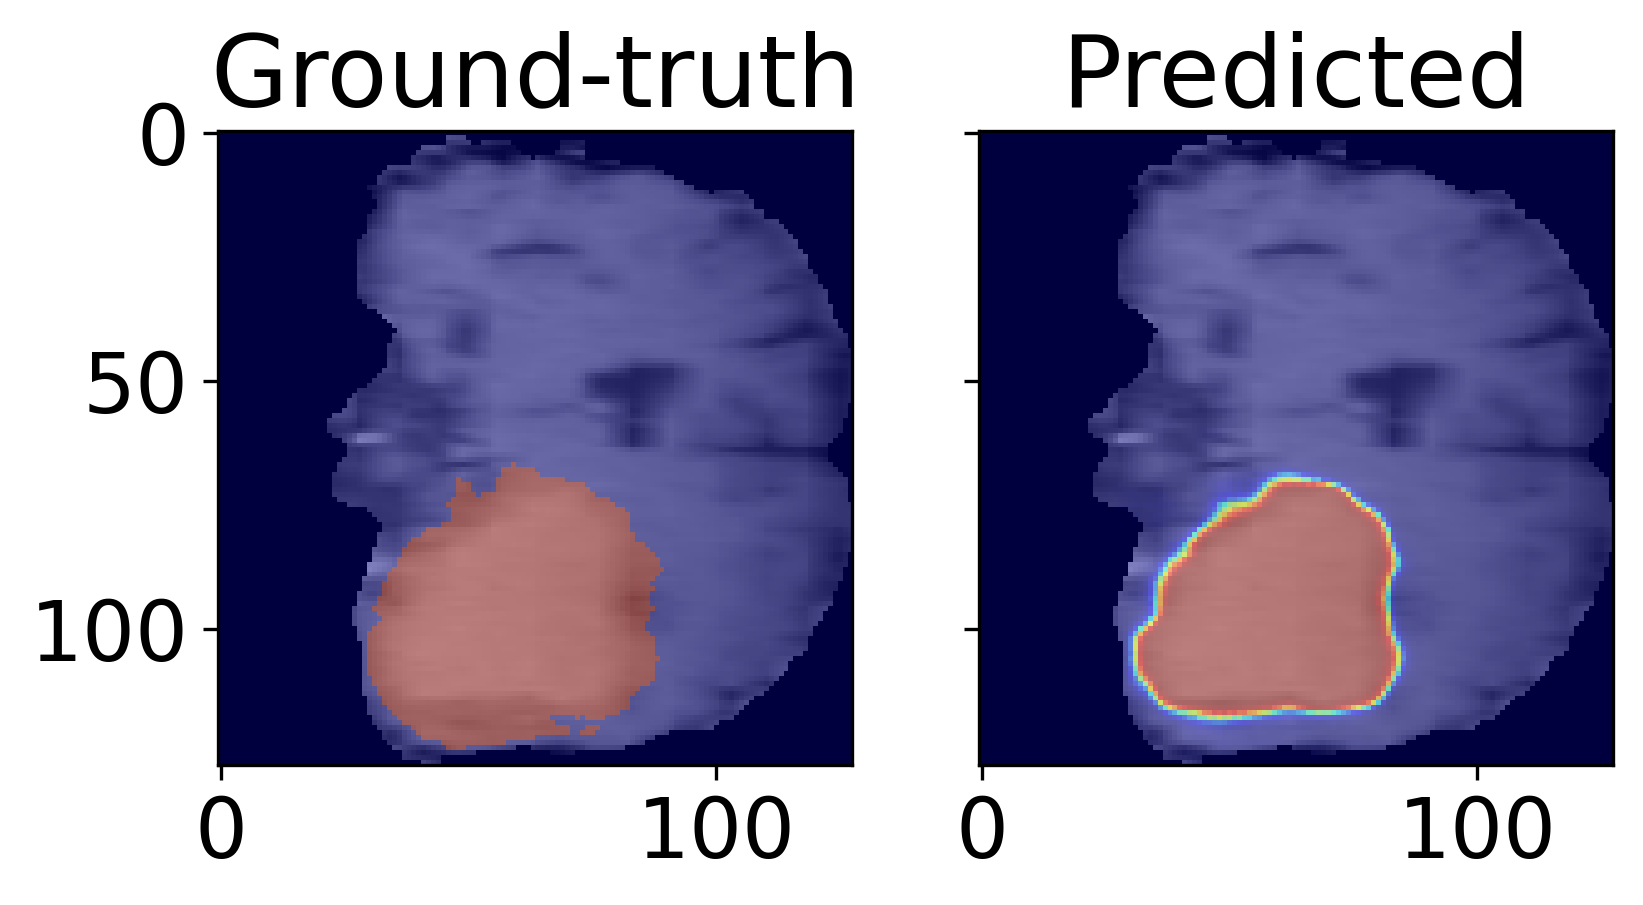

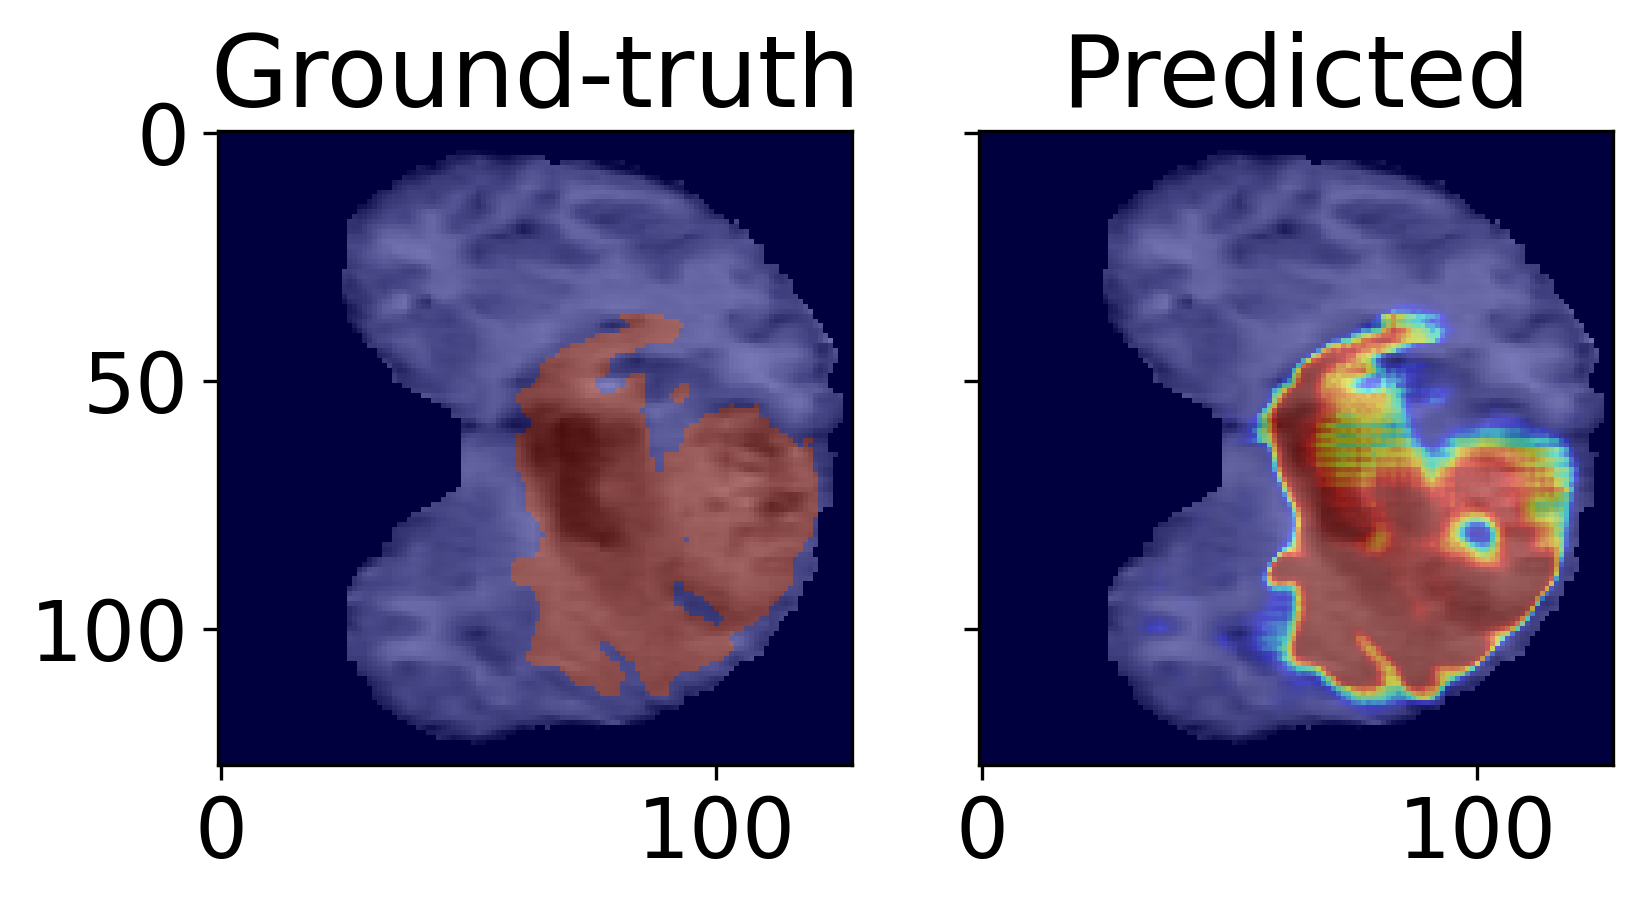

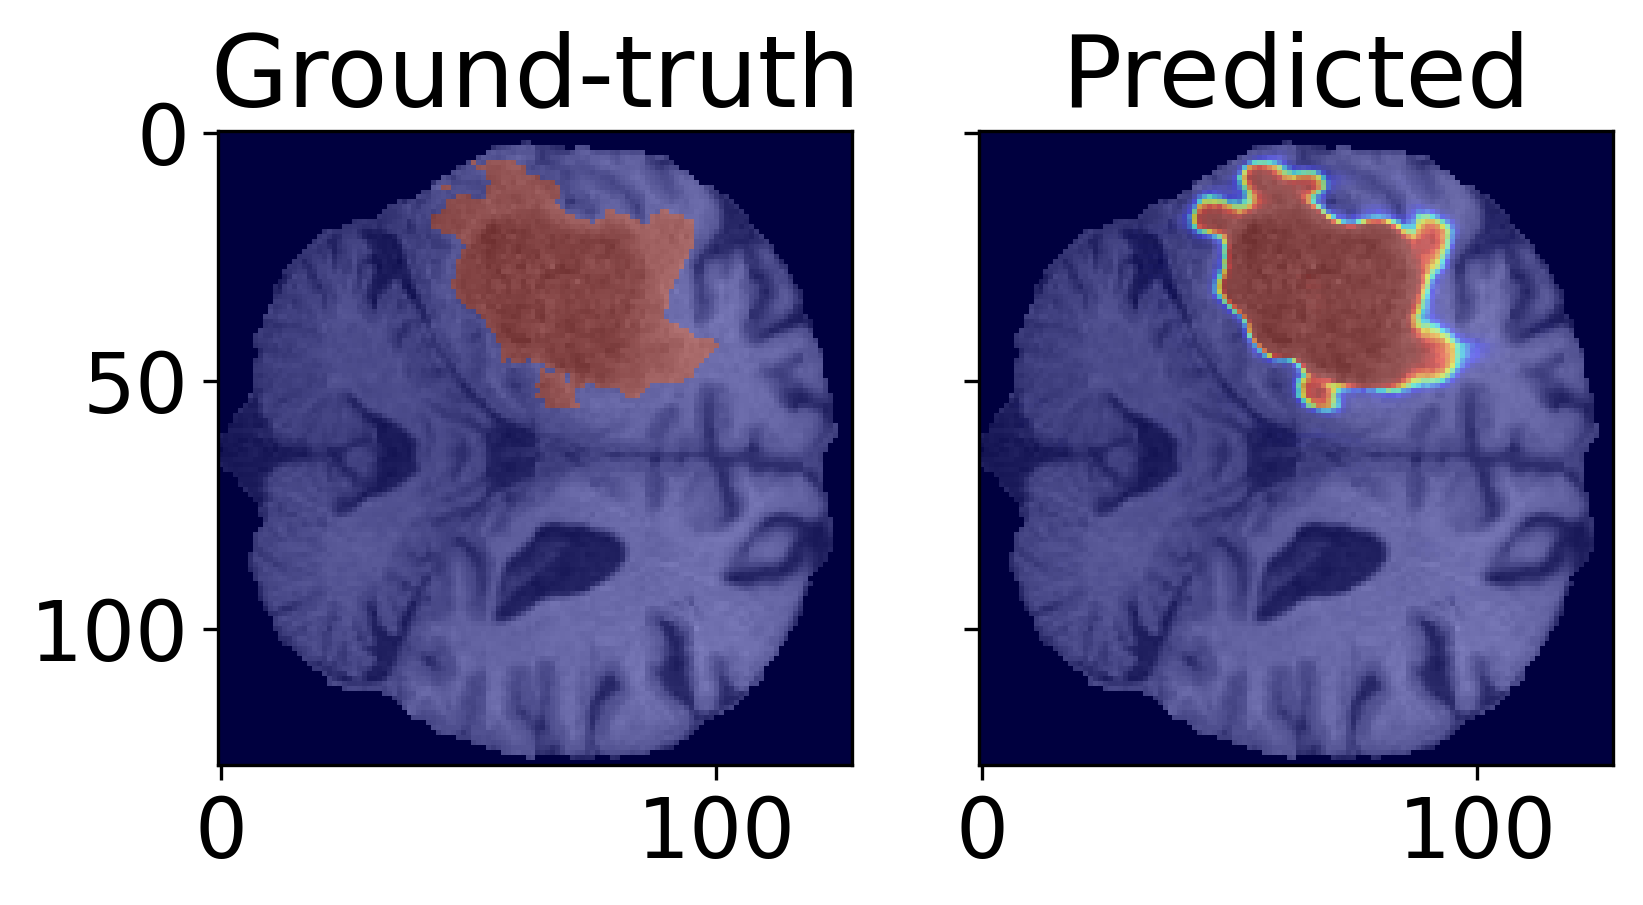

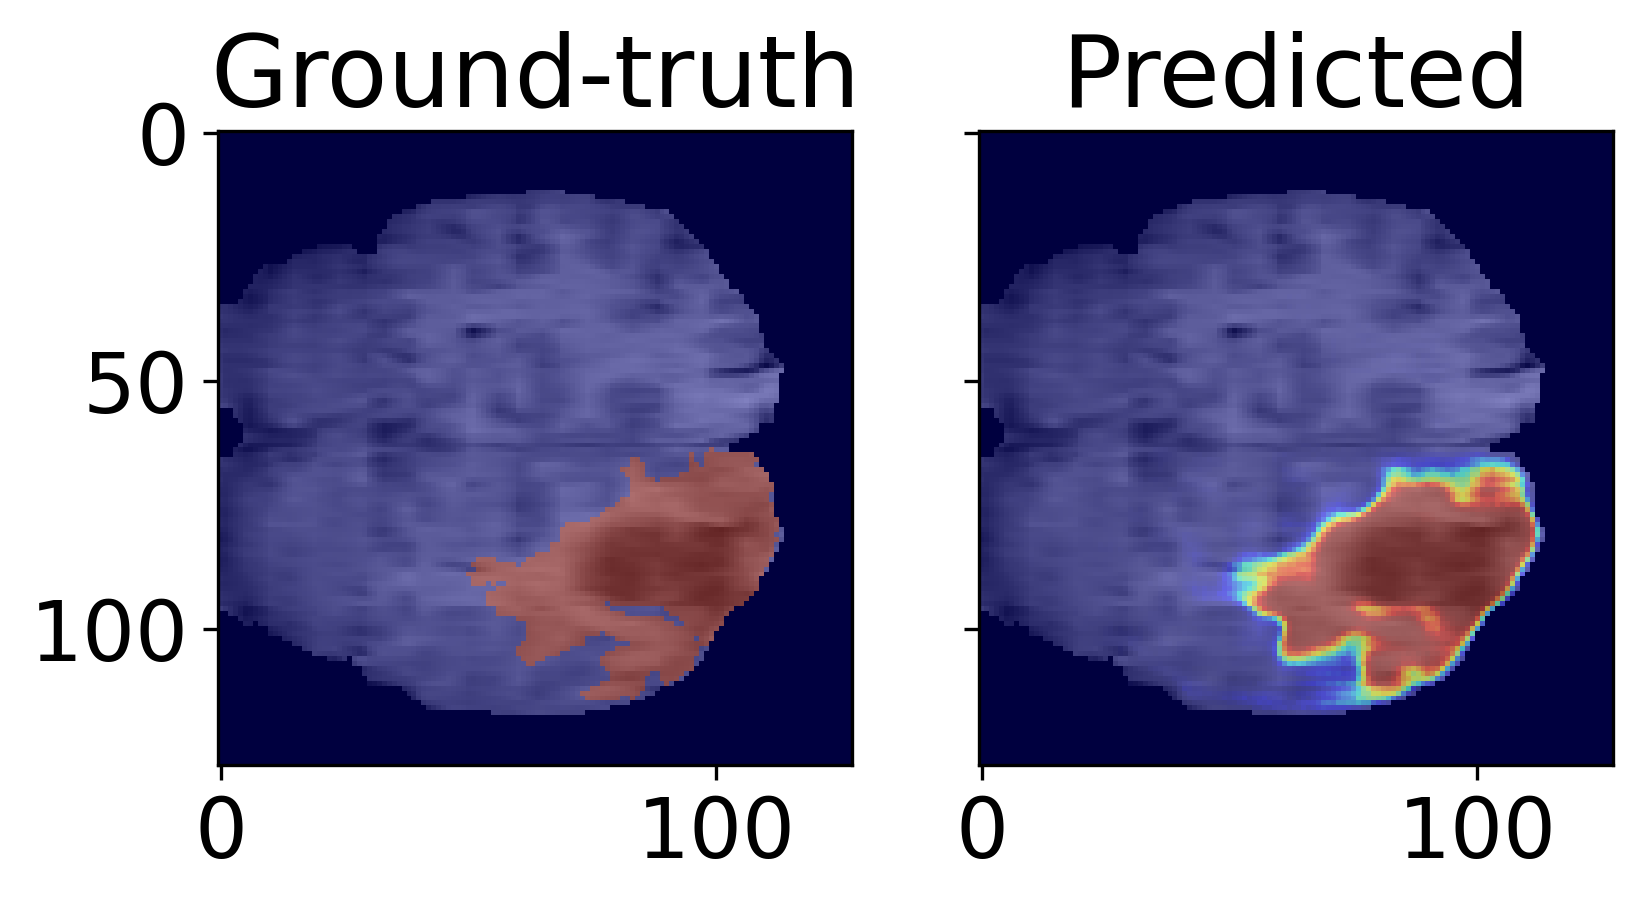

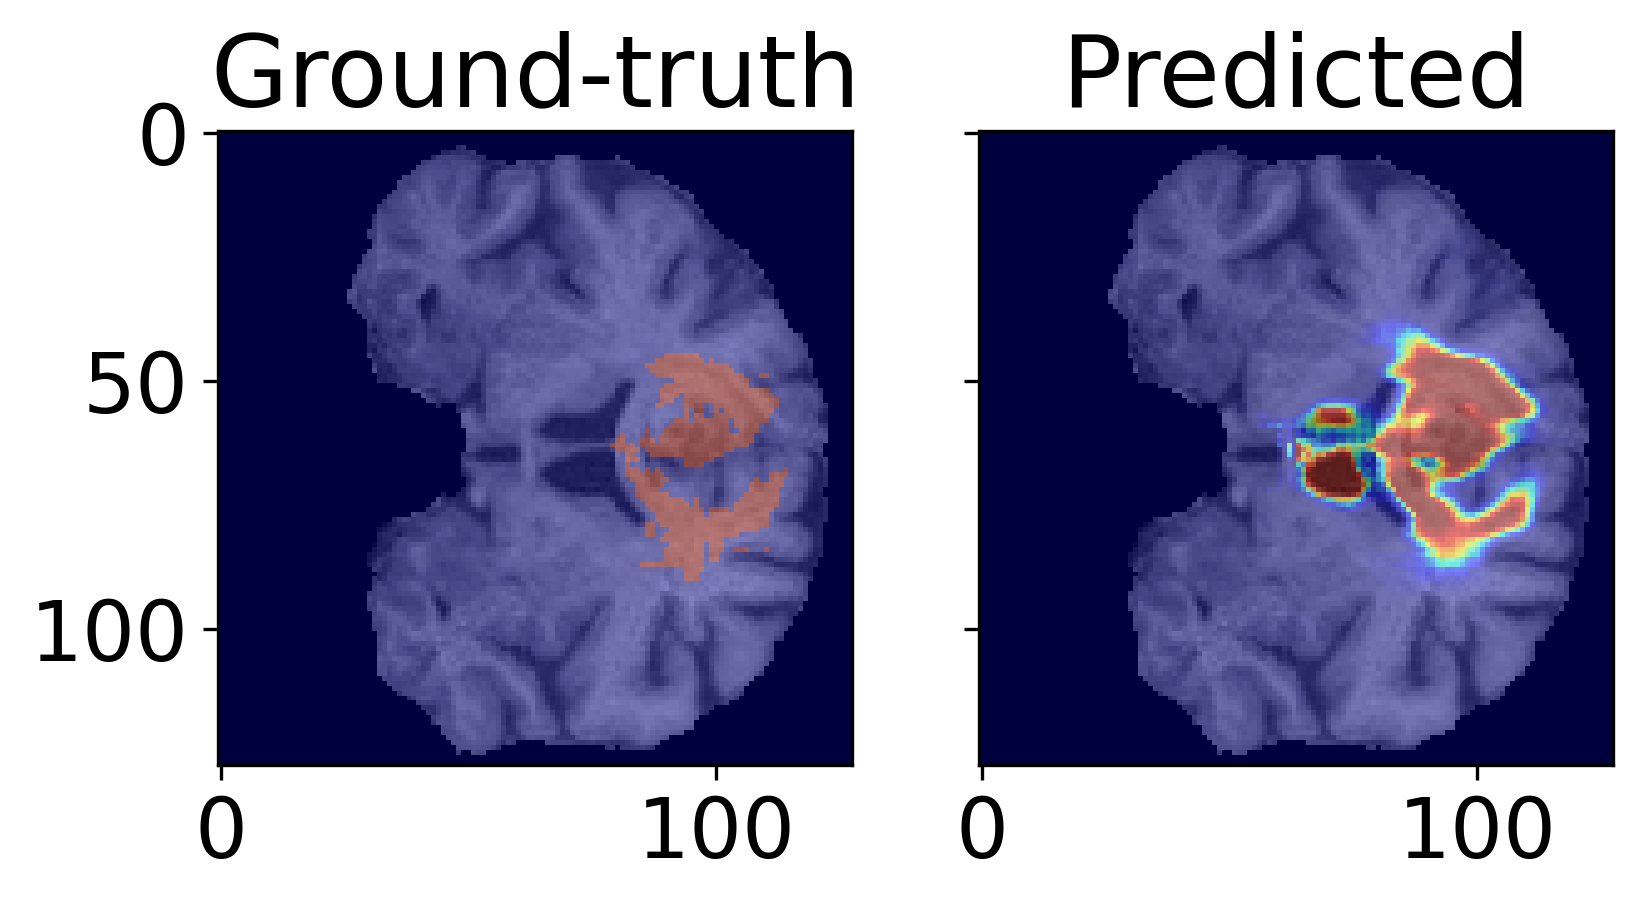

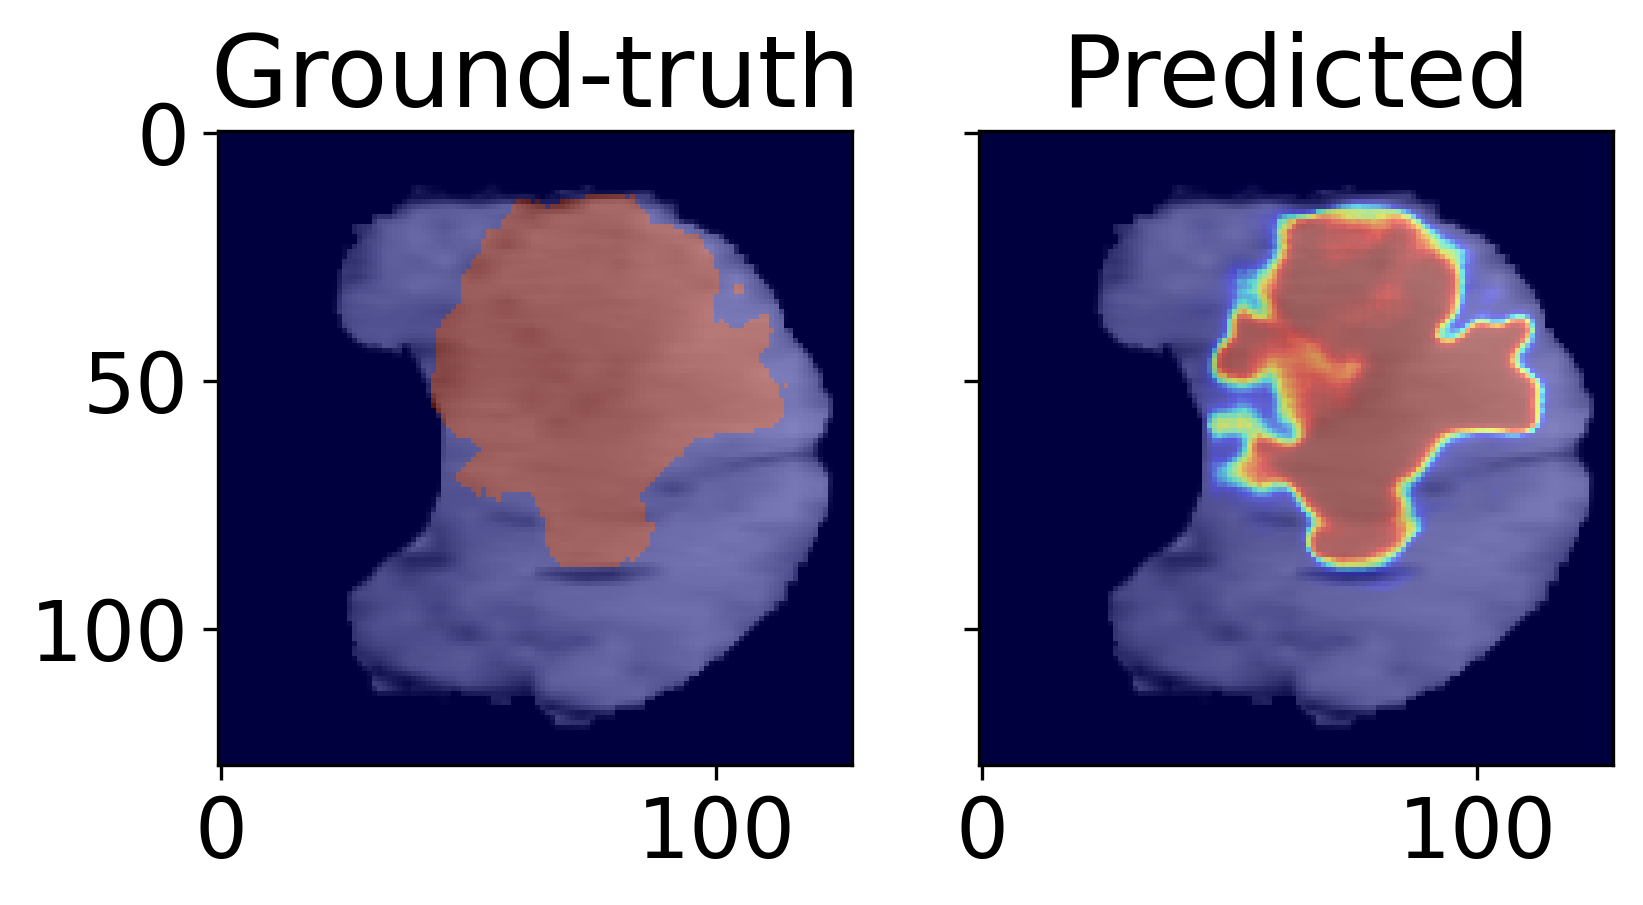

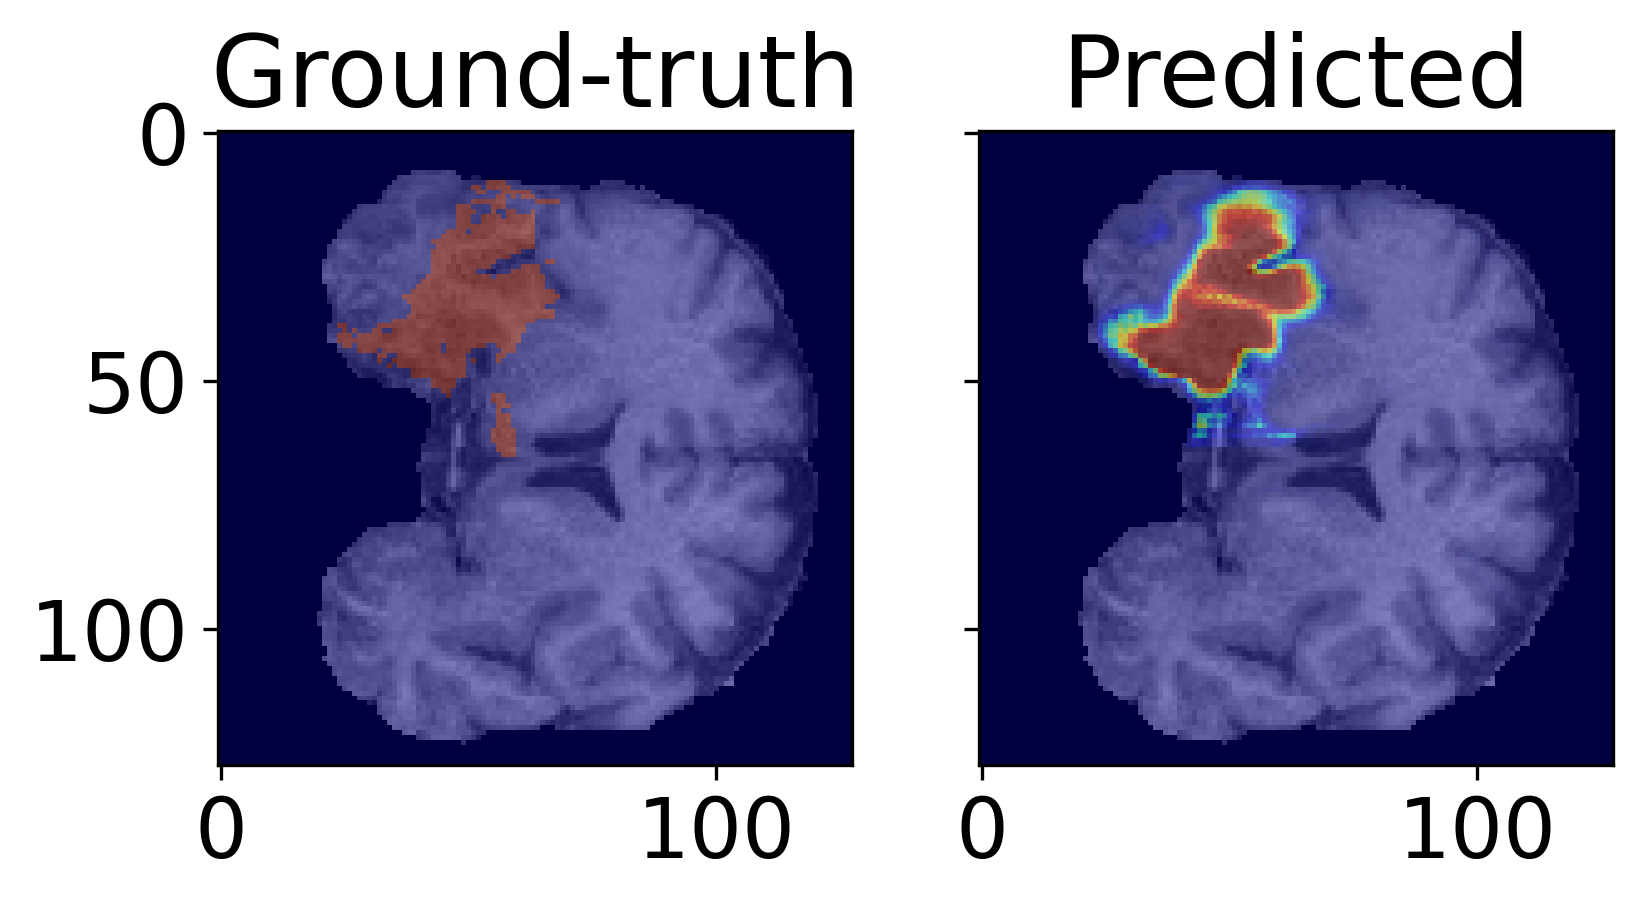

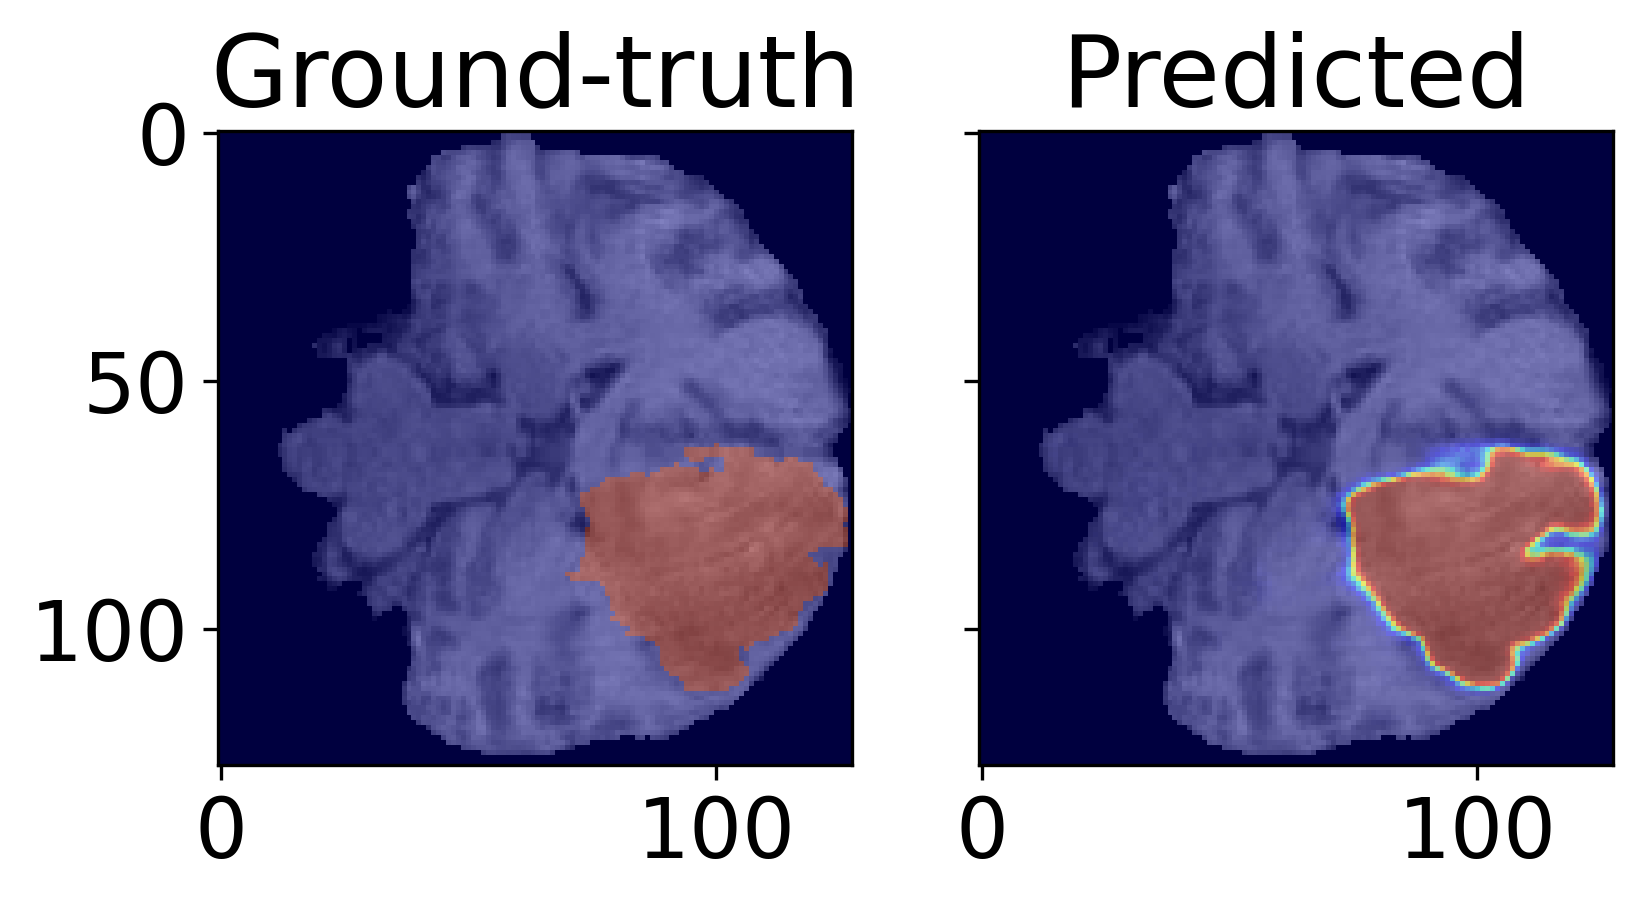

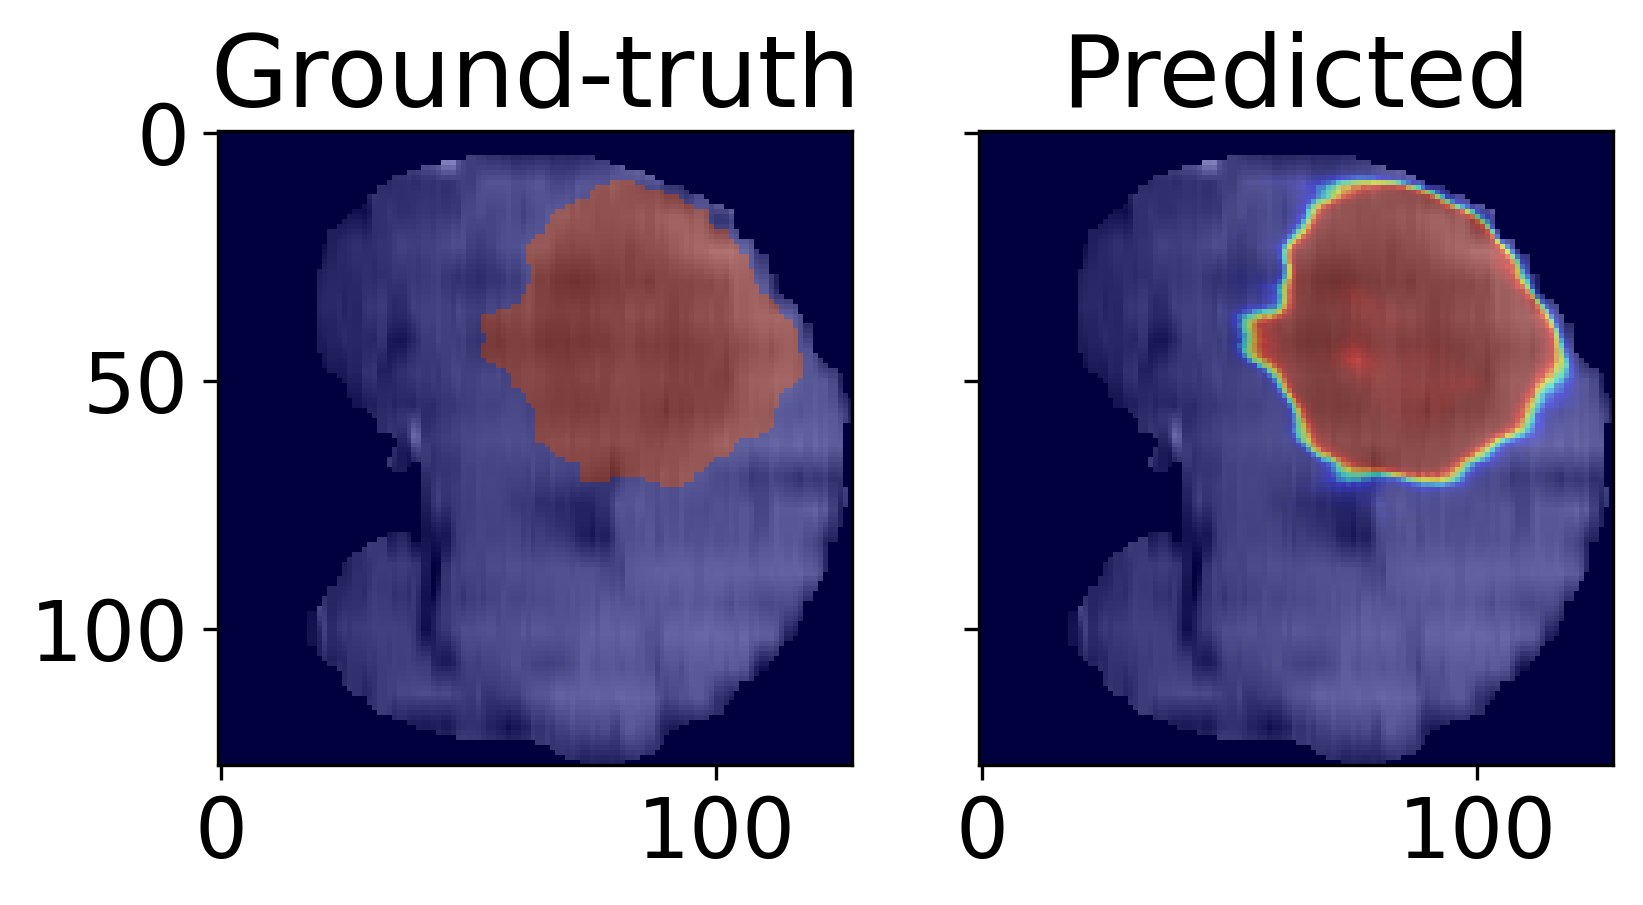

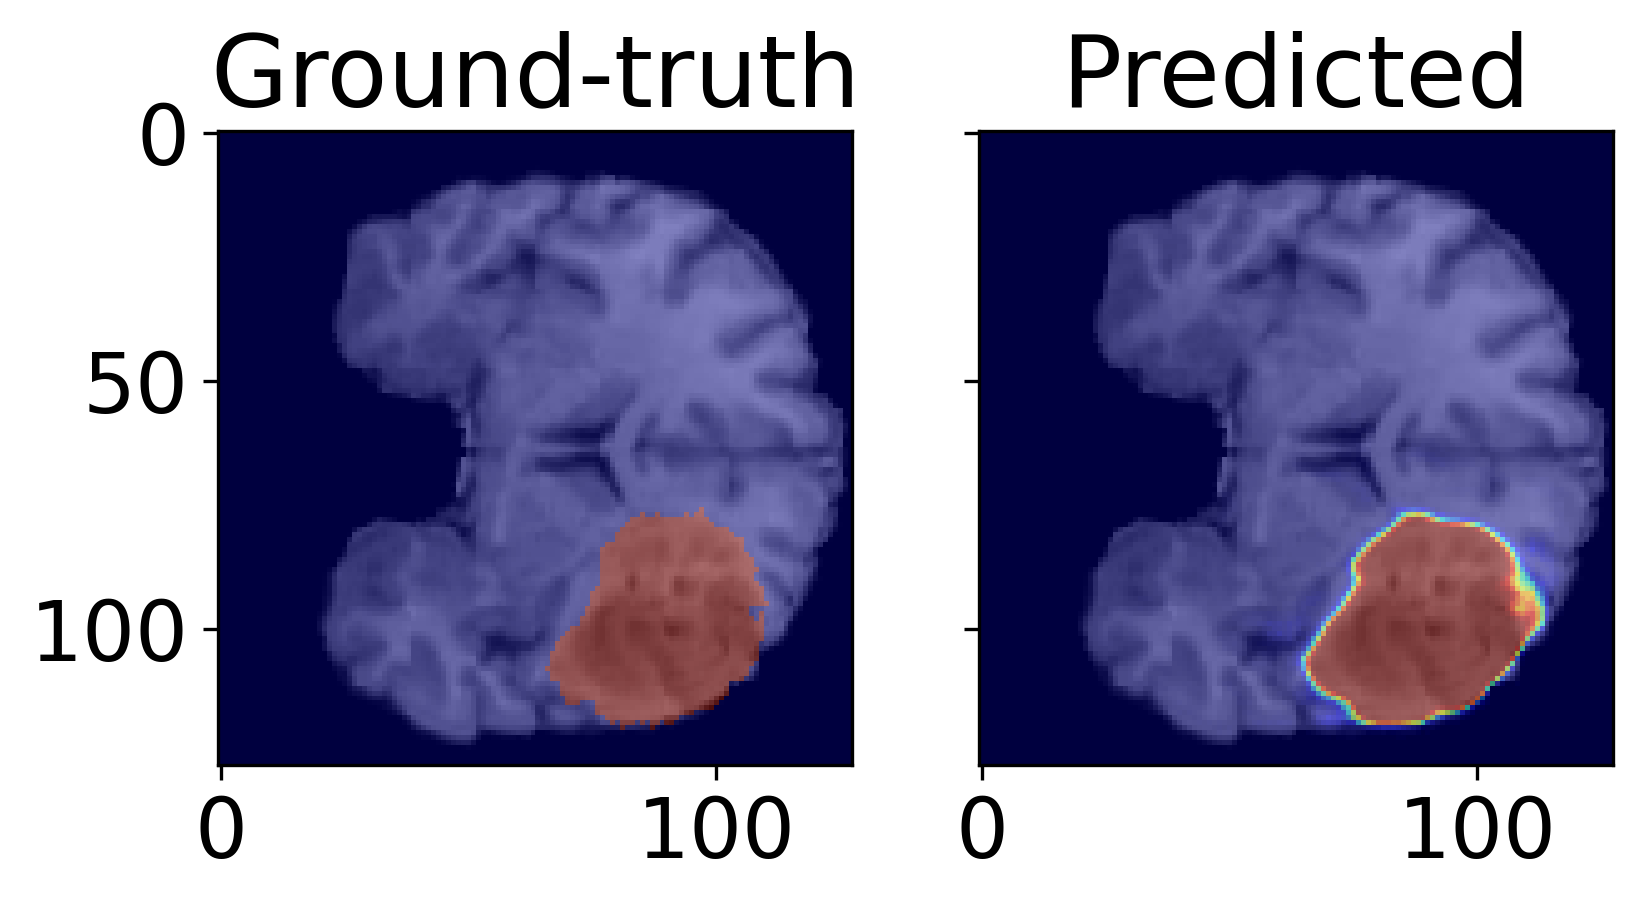

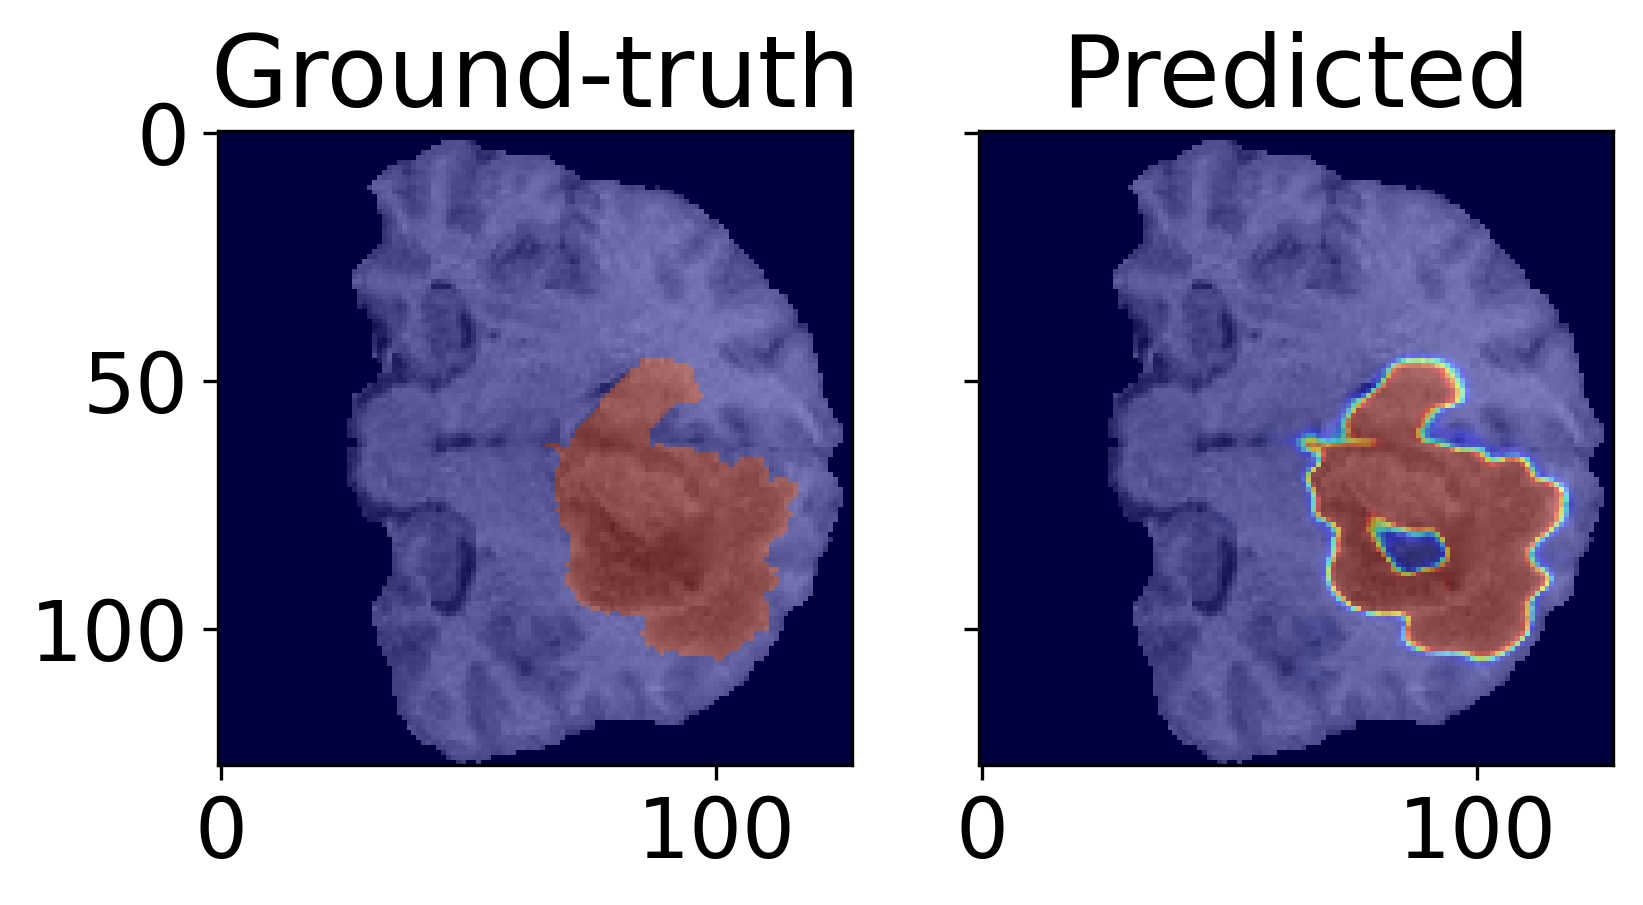

In [19]:
# label = 'n54'

for label in brains.keys():

    brain = brains[label][0]
    label_gt = labels_gt[label]
    label_pred = best_val_preds[label] #labels_pred[label]
    mask = labels_pred[label]

    fig, ax = plt.subplots(1,2, sharex=True, sharey=True, dpi=300)
    X_max, Y_max, Z_max = brain.shape

    y_slice_pos = label_gt.sum(axis=(0,-1)).argmax()

    brain_slice = brain[:,y_slice_pos,:]
    ax[0].imshow(brain_slice, 'gray')
    ax[0].imshow(label_gt[:,y_slice_pos,:], 'jet', interpolation='none', alpha=0.5)
    ax[0].set_title('Ground-truth')

    mask_slice = brain[:,y_slice_pos,:]
    ax[1].imshow(brain_slice, 'gray')
    ax[1].imshow(label_pred[:,y_slice_pos,:], 'jet', interpolation='none', alpha=0.5)
    ax[1].set_title('Predicted')
    
#     fig.suptitle(f'Label: {label}')

    # plt.colorbar()

    plt.show()

All train good predictions are in the same temporal lobe!